# Case 2: Collaborative Filtering via Deep Learning
-----

In this case, there are two main tasks:

- First, you need to build a deep learning model to predict the movie ratings.

- Then you will analyze the predicted ratings and provide an estimate of the movie valuation.

## Instructions

You need to fill in the missing code and submit the following files on Canvas
site:

1. A report in the pdf format containing the plots and the answers to the questions stated in the provided Jupyter notebook (Please read carefully the notebook and make sure answer every question);

2. The complete Jupyter notebook containing all your PyTorch code with explanations, along with
a Markdown text explaining different parts if needed.

---
## Introduction

One very common problem to solve is when you have a number of users and a number of products, and you want to recommend which products are most likely to be useful for which users. There are many variations of this: for example, recommending movies (such as on Netflix), figuring out what to highlight for a user on a home page, deciding what stories to show in a social media feed, and so forth. There is a general solution to this problem, called *collaborative filtering*, which works like this: look at what products the current user has used or liked, find other users that have used or liked similar products, and then recommend other products that those users have used or liked.

For example, on Netflix you may have watched lots of movies that are science fiction, full of action, and were made in the 1970s. Netflix may not know these particular properties of the films you have watched, but it will be able to see that other people that have watched the same movies that you watched also tended to watch other movies that are science fiction, full of action, and were made in the 1970s. In other words, to use this approach we don't necessarily need to know anything about the movies, except who like to watch them.

There is actually a more general class of problems that this approach can solve, not necessarily involving users and products. Indeed, for collaborative filtering we more commonly refer to *items*, rather than *products*. Items could be links that people click on, diagnoses that are selected for patients, and so forth.

The key foundational idea is that of *latent factors*. In the Netflix example, we started with the assumption that you like old, action-packed sci-fi movies. But you never actually told Netflix that you like these kinds of movies. And Netflix never actually needed to add columns to its movies table saying which movies are of these types. Still, there must be some underlying concept of sci-fi, action, and movie age, and these concepts must be relevant for at least some people's movie watching decisions.



---
In this case, we'll build an explicit feedback recommender system: that is, a model that takes into account explicit feedback signals (like ratings) to recommend new content. We'll use an approach first made popular by the [Netflix prize](https://en.wikipedia.org/wiki/Netflix_Prize) contest: [matrix factorization](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf).

The basic idea is very simple:

1. Start with user-item-rating triplets, conveying the information that user _i_ gave some item _j_ rating _r_.
2. Represent both users and items as high-dimensional vectors of numbers. For example, a user could be represented by `[0.3, -1.2, 0.5]` and an item by `[1.0, -0.3, -0.6]`.
3. The representations should be chosen so that, when we multiplied together (via [dot products](https://en.wikipedia.org/wiki/Dot_product)), we can recover the original ratings.
4. The utility of the model then is derived from the fact that if we multiply the user vector of a user with the item vector of some item they _have not_ rated, we hope to obtain a predicition for the rating they would have given to it had they seen it.

<img src='https://storage.googleapis.com/gweb-cloudblog-publish/images/f1-collab_filtering.max-900x900.png?raw=true' width=50% />

We do not have access to Netflix's entire dataset of movie watching history, but there is a great dataset that we can use, called [MovieLens](https://grouplens.org/datasets/movielens/). This dataset contains tens of millions of movie rankings (a combination of a movie ID, a user ID, and a numeric rating).

We start with importing the [Movielens 1M dataset](https://grouplens.org/datasets/movielens/1M/).  It contains 1,000,209 anonymous ratings of approximately 3,706 movies made by 6,040 MovieLens users who joined MovieLens in 2000.

## Preparations

We first import the packages and download the data.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import imp
import numpy as np

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

# this line need to be changed if not on colab:
data_folder = '/content/'


ML_1M_URL = "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
ML_1M_FILENAME = op.join(data_folder,ML_1M_URL.rsplit('/', 1)[1])
ML_1M_FOLDER = op.join(data_folder,'ml-1m')

In [ ]:
if not op.exists(ML_1M_FILENAME):
    print('Downloading %s to %s...' % (ML_1M_URL, ML_1M_FILENAME))
    urlretrieve(ML_1M_URL, ML_1M_FILENAME)

if not op.exists(ML_1M_FOLDER):
    print('Extracting %s to %s...' % (ML_1M_FILENAME, ML_1M_FOLDER))
    ZipFile(ML_1M_FILENAME).extractall(data_folder)

Extracting /content/ml-1m.zip to /content/ml-1m...


There are four different files:

- README
- movies.dat
- ratings.dat
- users.dat

You may read README to get the description of each dat files.

## Data analysis and formating

We start by loading the data with [Python Data Analysis Library](http://pandas.pydata.org/)

Note that the columns are separated by :: in the data.

In [ ]:
import pandas as pd
all_ratings = pd.read_csv(op.join(ML_1M_FOLDER, 'ratings.dat'), sep='::',
                          names=["user_id", "item_id", "ratings", "timestamp"],engine='python')
all_ratings.head()

,user_id,item_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


When showing the data, we would rather see movie titles than their IDs. The `movies.dat` contains the correspondence of IDs to movie titles.

In [ ]:
list_movies_names = []
list_item_ids = []
with open(op.join(ML_1M_FOLDER, 'movies.dat'), encoding = "ISO-8859-1") as fp:
    for line in fp:
        list_item_ids.append(line.split('::')[0])
        list_movies_names.append(line.split('::')[1])

movies_names = pd.DataFrame(list(zip(list_item_ids, list_movies_names)),
               columns =['item_id', 'item_name'])
movies_names.head()

,item_id,item_name
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


Here we add the title of the movies to the `all_ratings` data.

In [ ]:
movies_names['item_id']=movies_names['item_id'].astype(int)
all_ratings['item_id']=all_ratings['item_id'].astype(int)
all_ratings = all_ratings.merge(movies_names,on='item_id')

In [ ]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975)
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975)
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975)
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975)
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975)


The dataframe `all_ratings` contains all the raw data for our problem.

In [ ]:
#number of entries
len(all_ratings)

1000209

In [ ]:
# statistics of ratings
all_ratings['ratings'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: ratings, dtype: float64

In [ ]:
# The ratings are 1, 2, 3, 4, 5
all_ratings['ratings'].unique()

array([5, 4, 3, 2, 1])

We now check the user IDs.

In [ ]:
all_ratings['user_id'].describe()

count    1.000209e+06
mean     3.024512e+03
std      1.728413e+03
min      1.000000e+00
25%      1.506000e+03
50%      3.070000e+03
75%      4.476000e+03
max      6.040000e+03
Name: user_id, dtype: float64

In [ ]:
# number of unique users
total_user_id = len(all_ratings['user_id'].unique())
print(total_user_id)

6040


We see that  the users seem to be indexed from 1 to 6040. Let's check that below using the following code.

In [ ]:
list_user_id = list(all_ratings['user_id'].unique())
list_user_id.sort()

In [ ]:
for i,j in enumerate(list_user_id):
    if j != i+1:
        print(i,j)

We can see that `list_user_id` contains contiguous indices from 1 to 6040.

We create a new column `user_num` to get an index from 0 to 6039 for users:

In [ ]:
all_ratings['user_num'] = all_ratings['user_id'].apply(lambda x :x-1)

In [ ]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name,user_num
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),0
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),1
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),11
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),14
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),16


We now look at movies.

In [ ]:
all_ratings['item_id'].describe()

count    1.000209e+06
mean     1.865540e+03
std      1.096041e+03
min      1.000000e+00
25%      1.030000e+03
50%      1.835000e+03
75%      2.770000e+03
max      3.952000e+03
Name: item_id, dtype: float64

In [ ]:
# number of unique rated items
total_item_id = len(all_ratings['item_id'].unique())
print(total_item_id)

3706


Here there is a clear problem: there are 3706 different movies but the range of `item_id` starts at 1 and ends at 3952. So there are gaps, so the first thing you will need to do is to create a new column `item_num` so that all movies are indexed from 0 to 3705.

In [ ]:
itemnum_2_itemid = list(all_ratings['item_id'].unique())
itemnum_2_itemid.sort()
itemid_2_itemnum = {c:i for i,c in enumerate(itemnum_2_itemid)}
all_ratings['item_num'] = all_ratings['item_id'].apply(lambda x: itemid_2_itemnum[x])

This function will verify that we have created `item_num` correctly.

In [ ]:
def check_ratings_num(df):
    item_num = set(df['item_num'])
    if item_num == set(range(len(item_num))):
        return True
    else:
        return False

In [ ]:
check_ratings_num(all_ratings)

True

In [ ]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name,user_num,item_num
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),0,1104
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),1,1104
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),11,1104
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),14,1104
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),16,1104


### Preliminary data analysis

**Exercises**: Find the top 10 most popular movies in the dataset and include the result in your report

In [ ]:
top_movies = all_ratings['item_name'].value_counts()
print(top_movies[0:10])

American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
Saving Private Ryan (1998)                               2653
Terminator 2: Judgment Day (1991)                        2649
Matrix, The (1999)                                       2590
Back to the Future (1985)                                2583
Silence of the Lambs, The (1991)                         2578
Name: item_name, dtype: int64


**Exercise**: Plot the histogram of popularity (x-axis: # of given ratings, y-axis: # of movies with the given # of ratings). Include the plot in your report.

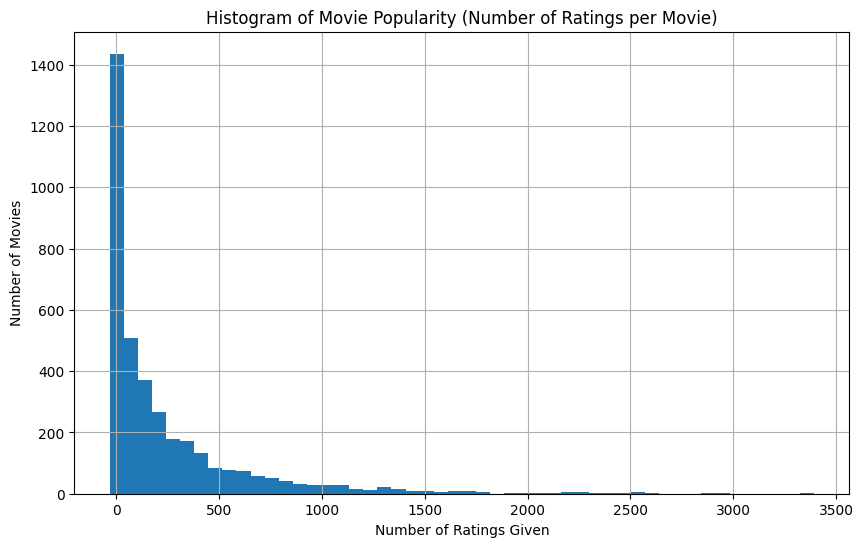

In [ ]:
rating_counts = all_ratings.groupby('item_num').size()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(rating_counts, bins=50, align='left')
plt.xlabel('Number of Ratings Given')
plt.ylabel('Number of Movies')
plt.title('Histogram of Movie Popularity (Number of Ratings per Movie)')
plt.grid(True)
plt.show()

**Exercise**: Plot the histogram of user activity (x-axis: # of given ratings, y-axis: # of users with the given # of ratings). Include the plot in your report.

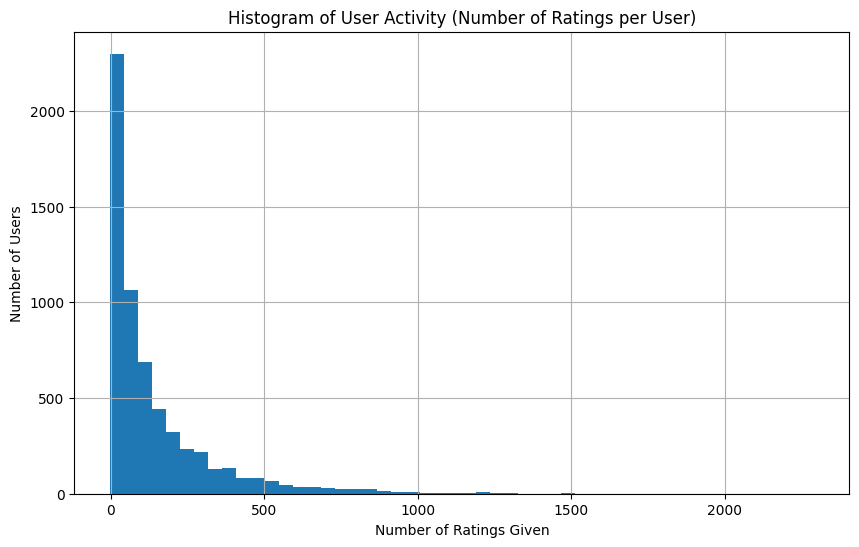

In [ ]:
# Adjusting the code to plot the histogram of user activity

# Counting the number of ratings given by each user
user_activity_counts = all_ratings.groupby('user_num').size()

# Plotting the histogram for user activity
plt.figure(figsize=(10, 6))
plt.hist(user_activity_counts, bins=50, align='left')
plt.xlabel('Number of Ratings Given')
plt.ylabel('Number of Users')
plt.title('Histogram of User Activity (Number of Ratings per User)')
plt.grid(True)
plt.show()


**Exercise**: Compute the average ratings for every movie and find the top 20 highly rated movies. Include the list of 20 highly rated movies and their ratings in your report. Are these highly rated movies popular?

In [ ]:
average_ratings = all_ratings.groupby('item_id')['ratings'].mean()

# Sorting the movies by their average rating in descending order and getting the top 20
top_20_movies = average_ratings.sort_values(ascending=False).head(20)

# Merging with the original dataframe to get movie names
top_20_movies_with_names = pd.merge(top_20_movies, all_ratings[['item_id', 'item_name']].drop_duplicates(), on='item_id')

# Checking if these highly rated movies are popular by seeing their rating counts
top_20_movies_popularity = all_ratings[all_ratings['item_id'].isin(top_20_movies.index)].groupby('item_id').size()

top_20_movies_with_names.set_index('item_id', inplace=True)
top_20_movies_with_names['popularity'] = top_20_movies_popularity

top_20_movies_with_names.reset_index(inplace=True)

top_20_movies_with_names

,item_id,ratings,item_name,popularity
0,989,5.000000,Schlafes Bruder (Brother of Sleep) (1995),1
1,3881,5.000000,Bittersweet Motel (2000),1
2,1830,5.000000,Follow the Bitch (1998),1
3,3382,5.000000,Song of Freedom (1936),1
4,787,5.000000,"Gate of Heavenly Peace, The (1995)",3
5,3280,5.000000,"Baby, The (1973)",1
6,3607,5.000000,One Little Indian (1973),1
7,3233,5.000000,Smashing Time (1967),2
8,3172,5.000000,Ulysses (Ulisse) (1954),1
9,3656,5.000000,Lured (1947),1


#### ANS:
The majority of the highly-rated movies (especially those with 5-star rating) are actually not popular and are reviewed by few people, but there are indeed some movies that are both highly-rated and popular such as Shawshank Redemption.

---
## Train, Validation, and Test Data

Now we will split the data in _train_, _val_ and _test_ be using a pre-defined function from [scikit-learn](http://scikit-learn.org/stable/)

In [ ]:
#Split the data into train, validation and test
from sklearn.model_selection import train_test_split

ratings_trainval, ratings_test = train_test_split(all_ratings, test_size=0.1, random_state=42)

ratings_train, ratings_val = train_test_split(ratings_trainval, test_size=0.1, random_state=42)

In [ ]:
user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['ratings']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['ratings']

In [ ]:
movies_not_train = list(set(all_ratings['item_id']) -set(item_id_train))
movies_not_train_name=set(all_ratings.loc[movies_not_train]['item_name'])
print(movies_not_train_name)

{'James and the Giant Peach (1996)', "One Flew Over the Cuckoo's Nest (1975)", 'My Fair Lady (1964)', 'Erin Brockovich (2000)'}


We see that a few movies are not rated in the train set. For those movies, it is hard to predict their ratings accurately.

---
## Data Load and Batching

Use GPU if available.

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We define a function to return a triplet of user_num, item_num, rating from the dataframe.

In [ ]:
def df_2_tensor(df, device):
    # return a triplet user_num, item_num, rating from the dataframe
    user_num = np.asarray(df['user_num'])
    item_num = np.asarray(df['item_num'])
    rating = np.asarray(df['ratings'])
    return torch.from_numpy(user_num).to(device), torch.from_numpy(item_num).to(device), torch.from_numpy(rating).to(device)

Below, we construct 3 tensors containing the `user_num`, `item_num` and `rating` for the training set. All tensors have the same shape so that `train_user_num[i]` watched `train_item_num[i]` and gave a rating of `train_rating[i]`.

In [ ]:
train_user_num, train_item_num, train_rating = df_2_tensor(ratings_train,device)

We now do the same thing for the validation and test sets.

In [ ]:
val_user_num, val_item_num, val_rating = df_2_tensor(ratings_val,device)
test_user_num, test_item_num, test_rating = df_2_tensor(ratings_test,device)

Now you need to construct a dataset and a dataloader. For this, you can define a first function taking as arguments the tensors defined above and returning a list (Hint: you may use the [zip function](https://www.w3schools.com/python/ref_func_zip.asp)); then a second function taking as argument a dataset, the batchsize and a boolean for the shuffling.

**Exercise**: Filling in the missing code below to construct dataset and dataloader.

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

def tensor_2_dataset(user, item, rating):
    # Combine the tensors into a single dataset
    dataset = zip(user, item, rating)
    return list(dataset)

def make_dataloader(dataset, bs, shuffle):
    # Create a DataLoader
    dataloader = DataLoader(dataset, batch_size=bs, shuffle=shuffle)
    return dataloader

In [ ]:
train_dataset = tensor_2_dataset(train_user_num,train_item_num, train_rating)
val_dataset = tensor_2_dataset(val_user_num,val_item_num,val_rating)
test_dataset = tensor_2_dataset(test_user_num, test_item_num, test_rating)

Load the train, validation, and test data in batchs of size 1024.

In [ ]:
train_dataloader = make_dataloader(train_dataset,1024,True)
val_dataloader = make_dataloader(val_dataset,1024, False)
test_dataloader = make_dataloader(test_dataset,1024,False)

---
## The model



In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

We will use some custom embeddings defined as below.

In [ ]:
class ScaledEmbedding(nn.Embedding):
    """
    Embedding layer that initialises its values
    to using a normal variable scaled by the inverse
    of the embedding dimension.
    """
    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.normal_(0, 1.0 / self.embedding_dim)
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0.0)


class ZeroEmbedding(nn.Embedding):
    """
    Used for biases.
    """

    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.zero_()
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0.0)

### Creating Our Own Embedding Module

Now, we define the `Model_dot`(class to represents users and items. It's composed of a 4 `embedding` layers:

- a `(num_users x latent_dim)` embedding layer to represent users,
- a `(num_items x latent_dim)` embedding layer to represent items,
- a `(num_users x 1)` embedding layer to represent user biases, and
- a `(num_items x 1)` embedding layer to represent item biases.







**Exercise**: Fill the missing code to define the embeddings.

In [ ]:
class DotModel(nn.Module):

    def __init__(self,
                 num_users,
                 num_items,
                 embedding_dim=32):

        super(DotModel, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_users = num_users
        self.num_items = num_items

        # TODO: generate user and item embeddigns using ScaledEmbedding
        # your code
        self.user_embeddings = ScaledEmbedding(num_users, embedding_dim)
        self.item_embeddings = ScaledEmbedding(num_items, embedding_dim)

        # TODO: generate bias embeddigns using ZeroEmbedding
        # your code
        self.user_biases =  ZeroEmbedding(num_users,1)
        self.item_biases =  ZeroEmbedding(num_items,1)


    def forward(self, user_ids, item_ids):
        # TODO: compute and return the predicted rating based on the embedding vectors and biases.
        # your code
        user_embedding = self.user_embeddings(user_ids)
        item_embedding = self.item_embeddings(item_ids)

        # Retrieve the biases for the users and items
        user_bias = self.user_biases(user_ids).squeeze()
        item_bias = self.item_biases(item_ids).squeeze()

        # Compute the dot product of user and item embeddings
        dot = (user_embedding * item_embedding).sum(1)

        # Add the bias terms and return the predicted rating
        return dot + user_bias + item_bias

In [ ]:
net = DotModel(total_user_id,total_item_id).to(device)

Now we check your network by taking  a batch from train loader.

In [ ]:
batch_user, batch_item, batch_rating = next(iter(train_dataloader))
batch_user, batch_item, batch_rating = batch_user.to(device), batch_item.to(device), batch_rating.to(device)

In [ ]:
predictions = net(batch_user, batch_item)
predictions.shape

torch.Size([1024])

We will use MSE loss defined below:

In [ ]:
def regression_loss(predicted_ratings, observed_ratings):
    return ((observed_ratings - predicted_ratings) ** 2).mean()

In [ ]:
loss=regression_loss(predictions,batch_rating)

In [ ]:
loss

tensor(13.9965, device='cuda:0', grad_fn=<MeanBackward0>)

## Train and test the model

Now we define `FactorizationModel` class  that allows us to train and evaluate the explicit factorization models.


- The `fit` function should take as argument a dataloader for the training and a dataloader for the validation. At the end of each epoch, you run the test method on the validation set. Then you print both the loss on the training set and on the validation set to see if you are overfitting.

- Weight decay, or *L2 regularization*, consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

**Exercise**: Filling in the missing code below to complete the training pass and validation pass.

In [ ]:
class FactorizationModel(object):

    def __init__(self, embedding_dim=32, n_iter=10, l2=0.0,
                 learning_rate=1e-2, device=device, net=None, num_users=None,
                 num_items=None,random_state=None):

        self._embedding_dim = embedding_dim
        self._n_iter = n_iter
        self._learning_rate = learning_rate
        self._l2 = l2
        self._device = device
        self._num_users = num_users
        self._num_items = num_items
        self._net = net
        self._optimizer = None
        self._loss_func = None
        self._random_state = random_state or np.random.RandomState()


    def _initialize(self):
        if self._net is None:
            self._net = DotModel(self._num_users, self._num_items, self._embedding_dim).to(self._device)

        self._optimizer = optim.Adam(
                self._net.parameters(),
                lr=self._learning_rate,
                weight_decay=self._l2
            )

        self._loss_func = regression_loss

    @property
    def _initialized(self):
        return self._optimizer is not None


    def fit(self, dataloader, val_dataloader, verbose=True):
        if not self._initialized:
            self._initialize()

        valid_loss_min = np.Inf # track change in validation loss
        train_losses, valid_losses, valid_maes =[], [], [] # track train losses, valid loss, and valid maes over epoches

        for epoch_num in range(self._n_iter):
            tot_train_loss = 0.0
            ###################
            # train the model #
            ###################
            #TODO: trainining loop:
            # your code
            for user_ids, item_ids, ratings in dataloader:
              # Move data to the device
              user_ids = user_ids.to(self._device)
              item_ids = item_ids.to(self._device)
              ratings = ratings.to(self._device)

              # Zero the parameter gradients
              self._optimizer.zero_grad()

              # Forward pass
              outputs = self._net(user_ids, item_ids)
              loss = self._loss_func(outputs, ratings)

              # Backward pass and optimize
              loss.backward()
              self._optimizer.step()

              tot_train_loss += loss.item()

            train_loss = tot_train_loss /len(dataloader)

            # Go to the validation loop
            valid_loss, valid_mae = self.test(val_dataloader)

            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            valid_maes.append(valid_mae)

            if verbose:
                print('Epoch {}: loss_train {}, loss_val {}'.format(epoch_num+1, train_loss,valid_loss))

            if np.isnan(train_loss) or train_loss == 0.0:
                raise ValueError('Degenerate train loss: {}'.format(train_loss))

            #TODO: Saving model if validation loss has decreased
            # your code
            if valid_loss < valid_loss_min:
              torch.save(self._net.state_dict(), 'best_model.pt')
              valid_loss_min = valid_loss
              if verbose:
                print('Validation loss decreased. Model saved.')

        return train_losses, valid_losses, valid_maes


    ######################
    # validate/Test the model #
    ######################
    def test(self,dataloader, verbose = False):
        self._net.eval()
        L1loss = torch.nn.L1Loss()
        tot_test_loss = 0.0
        tot_test_mae = 0.0

        # TODO: validation/testing loop
        # your code here (mae = mean absolute error)
        with torch.no_grad():
          for user_ids, item_ids, ratings in dataloader:
              # Move data to the device
              user_ids = user_ids.to(self._device)
              item_ids = item_ids.to(self._device)
              ratings = ratings.to(self._device)

              # Forward pass
              outputs = self._net(user_ids, item_ids)

              # Calculate loss
              loss = self._loss_func(outputs, ratings)
              tot_test_loss += loss.item()

              # Calculate MAE (Mean Absolute Error)
              mae = L1loss(outputs, ratings)
              tot_test_mae += mae.item()

        test_loss = tot_test_loss / len(dataloader)
        test_mae = tot_test_mae / len(dataloader)
        if verbose:
            print(f"RMSE: {np.sqrt(test_loss)}, MAE: {test_mae}")
        return test_loss, test_mae

In [ ]:
#TODO: Construct your model using FactorizationModel
# your code
model = FactorizationModel(embedding_dim=32, n_iter=75, l2=0.00001,
                 learning_rate=0.001, device=device, net=None, num_users=6040,
                 num_items=3706,random_state=42)

**Exercise**: Train the model and plot the train losses and valid losses over epoches.
At which epoch, you would stop the training? Include the plot and your answer in the report.

Epoch 1: loss_train 7.700363970766164, loss_val 1.4687580032782122
Validation loss decreased. Model saved.
Epoch 2: loss_train 1.0633604707892494, loss_val 0.9158097552982244
Validation loss decreased. Model saved.
Epoch 3: loss_train 0.8724842967860627, loss_val 0.8634178421714089
Validation loss decreased. Model saved.
Epoch 4: loss_train 0.8443381606478884, loss_val 0.8497013781558383
Validation loss decreased. Model saved.
Epoch 5: loss_train 0.833007548042018, loss_val 0.8412799896164374
Validation loss decreased. Model saved.
Epoch 6: loss_train 0.8212241170683292, loss_val 0.8293137496167963
Validation loss decreased. Model saved.
Epoch 7: loss_train 0.8062656555663456, loss_val 0.8156040839173577
Validation loss decreased. Model saved.
Epoch 8: loss_train 0.7888779291751409, loss_val 0.8037517761642282
Validation loss decreased. Model saved.
Epoch 9: loss_train 0.7732016681270166, loss_val 0.7931862222877416
Validation loss decreased. Model saved.
Epoch 10: loss_train 0.7581258

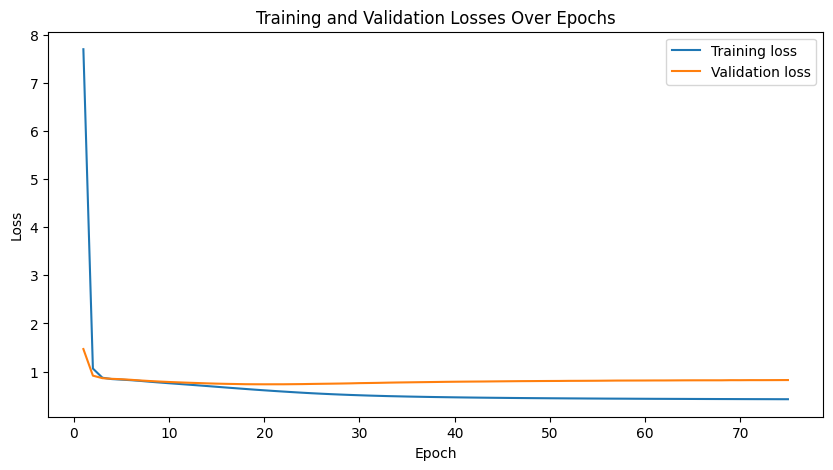

In [ ]:
train_losses, valid_losses, valid_maes = model.fit(train_dataloader, val_dataloader)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, 76), train_losses, label='Training loss')
plt.plot(range(1, 76), valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses Over Epochs')
plt.show()

#### ANS: We should stop at Epoch 20, because after that the validation loss started to increase.

**Exercise**: Now, let's compute the RMSE and mean absolute error on the test data. Include your answers in your report.

In [ ]:
test_loss, test_mae = model.test(test_dataloader, True)

RMSE: 0.9075941745234222, MAE: 0.7059394394864842


## Optimize your model and training

**Exercise**: Play with the hyperparameters (embedding_dim, n_iter, learning_rate, L2 regularization, etc) to beat the benchmarks presented in [Surprise](https://github.com/NicolasHug/Surprise). List the hyperparameters and the RMSE and MAE on test data in the report. Save the model state to `model_cf.pt` and submit it to Canvas.


Here is comparison between the best benckmarks in [Surprise](https://github.com/NicolasHug/Surprise) and your model after hyperparameters tunning.

| [Movielens 1M](https://grouplens.org/datasets/movielens/1m)                                                                             |   RMSE |   MAE |
|:----------------------------------------------------------------------------------------------------------------------------------------|-------:|------:|
| [SVD++ (cache_ratings=False)](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp)  |  0.862 | 0.672 |
| [SVD++ (cache_ratings=True)](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp)  |  0.862 | 0.672 |
| **Yours**|  0.856 | 0.672 |



In [ ]:
best_model = FactorizationModel(embedding_dim=32, n_iter=20, l2=0.00001,
                 learning_rate=0.001, device=device, net=None, num_users=6040,
                 num_items=3706,random_state=42)

In [ ]:
best_model.fit(train_dataloader, val_dataloader, verbose=True)

Epoch 1: loss_train 7.640898784453219, loss_val 1.4850488074801185
Validation loss decreased. Model saved.
Epoch 2: loss_train 1.0681948273470907, loss_val 0.914069998670708
Validation loss decreased. Model saved.
Epoch 3: loss_train 0.8655978916871427, loss_val 0.8525053648786112
Validation loss decreased. Model saved.
Epoch 4: loss_train 0.8267762915353583, loss_val 0.830540390854532
Validation loss decreased. Model saved.
Epoch 5: loss_train 0.8060156052762811, loss_val 0.8137713792649183
Validation loss decreased. Model saved.
Epoch 6: loss_train 0.789584146680856, loss_val 0.8038804239847444
Validation loss decreased. Model saved.
Epoch 7: loss_train 0.7750448207512046, loss_val 0.793675418604504
Validation loss decreased. Model saved.
Epoch 8: loss_train 0.759955455257435, loss_val 0.7833732651038603
Validation loss decreased. Model saved.
Epoch 9: loss_train 0.7445709076192644, loss_val 0.7737680138512091
Validation loss decreased. Model saved.
Epoch 10: loss_train 0.72940297484

([7.640898784453219,
  1.0681948273470907,
  0.8655978916871427,
  0.8267762915353583,
  0.8060156052762811,
  0.789584146680856,
  0.7750448207512046,
  0.759955455257435,
  0.7445709076192644,
  0.7294029748499996,
  0.7154101852816764,
  0.7024409217816411,
  0.6906197904185816,
  0.6790534510756984,
  0.667330628543189,
  0.6555145318911533,
  0.6431614266652049,
  0.6309373563136718,
  0.6185725085211523,
  0.6061989374534048],
 [1.4850488074801185,
  0.914069998670708,
  0.8525053648786112,
  0.830540390854532,
  0.8137713792649183,
  0.8038804239847444,
  0.793675418604504,
  0.7833732651038603,
  0.7737680138512091,
  0.7659443332390352,
  0.7598767138340257,
  0.7552370429039001,
  0.7513923516327684,
  0.7466610880060629,
  0.7433599436824972,
  0.7403482293540781,
  0.7381312671032819,
  0.7357560755176977,
  0.7348209233446554,
  0.7346277257258241],
 [0.9644105224446817,
  0.7560857703739946,
  0.730393535034223,
  0.7203414677218958,
  0.7128379832614552,
  0.708579924973

In [ ]:
test_loss2, test_mae2 = best_model.test(test_dataloader, True)

RMSE: 0.856586430735827, MAE: 0.672347149678639


In [ ]:
best_model._net

DotModel(
  (user_embeddings): ScaledEmbedding(6040, 32)
  (item_embeddings): ScaledEmbedding(3706, 32)
  (user_biases): ZeroEmbedding(6040, 1)
  (item_biases): ZeroEmbedding(3706, 1)
)

In [ ]:
torch.save(best_model._net.state_dict(), 'model_cf.pt')

## Interpreting Biases

Now you need to rank the movies according to their bias. For this, you need to recover the biases of the movies, make a list of the pairs `[name of the movie, its bias]` and then sort this list according to the biases. You can use the method sort of a list.

**Exercise**: What are your top 10 movies with the largest values of movie bias? What do you think about this ranking? Include your answers in your report.

In [ ]:
#TODO: retreive the bias of the movies from your optimized model and store it in the numpy array item_bais_np
item_bias_np = best_model._net.item_biases.weight.data
item_bias_np = item_bias_np.squeeze()

In [ ]:
# construct a dictionary that maps item_num to item_name, and vice versa
numitem_2_name = {i:name for name,i in np.asarray(all_ratings[['item_name', 'item_num']])}
name_2_numitem = {name:i for name,i in np.asarray(all_ratings[['item_name', 'item_num']])}

In [ ]:
# Construct a list of movie names and the corresponding bias.
list_name_bias = [[name, item_bias_np[name_2_numitem[name]]] for name in list(ratings_train['item_name'].unique())]

In [ ]:
#TODO: sort the movie names by biases and output the top 10 movie names with the largest biases.
# your code
# Sort the list by bias value in descending order
sorted_by_bias = sorted(list_name_bias, key=lambda x: x[1], reverse=True)

# Extract the names of the top 10 movies
top_10 = [name for name, bias in sorted_by_bias[:10]]

# Display the top 10 movies
top_10

['Sanjuro (1962)',
 'Shawshank Redemption, The (1994)',
 'Sixth Sense, The (1999)',
 "Schindler's List (1993)",
 'Last Days, The (1998)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Godfather, The (1972)',
 'Raiders of the Lost Ark (1981)',
 'Usual Suspects, The (1995)',
 'Wrong Trousers, The (1993)']

bold text#### ANS: The top 10 movies with the largest values of movie bias are 'Sanjuro (1962)',
 'Shawshank Redemption, The (1994)',
 'Sixth Sense, The (1999)',
 "Schindler's List (1993)",
 'Last Days, The (1998)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Godfather, The (1972)',
 'Raiders of the Lost Ark (1981)',
 'Usual Suspects, The (1995)',
 'Wrong Trousers, The (1993)', and so on, are really widely-known, and the high bias may due to their popularity. Their long-standing high profile may lead them to be rated higher than what would be predicted solely based on user and movie correlation and hence a high bias.

## PCA of movies' embeddings

Now you can also play with the embeddings learned by your algorithm for the movies.

It is not quite so easy to directly interpret the embedding matrices. There are just too many factors for a human to look at. But there is a technique that can pull out the most important underlying *directions* in such a matrix, called *principal component analysis* (PCA). We will not be going into this in detail in this class, because it is not particularly important for you to understand to be a deep learning practitioner. We can visualize the movie embeddings based on two of the strongest PCA components.

**Exercise**: Do you observe anything interesting from the movie embeddings? Include the plot of the movie embeddings and your answer in your report.

In [ ]:
from sklearn.decomposition import PCA
from operator import itemgetter

In [ ]:
#TODO: retrive your movie embedding vectors and store them as a numpy matrix
item_emb_np = best_model._net.item_embeddings.weight.data.cpu().numpy()

In [ ]:
#Here we perform PCA to extract the 4 principal components
pca = PCA(n_components=4)
latent_fac = pca.fit_transform(item_emb_np)

Next, we plot the embeddings of the top 80 mostly rated movies using the second and third principal components.

In [ ]:
#Here we get the top 1000 mostly rated movies
g = all_ratings.groupby('item_name')['ratings'].count()
most_rated_movies = g.sort_values(ascending=False).index.values[:1000]
# we get the corresponding movie numbers
most_rated_movies_num = [name_2_numitem[n] for n in most_rated_movies]

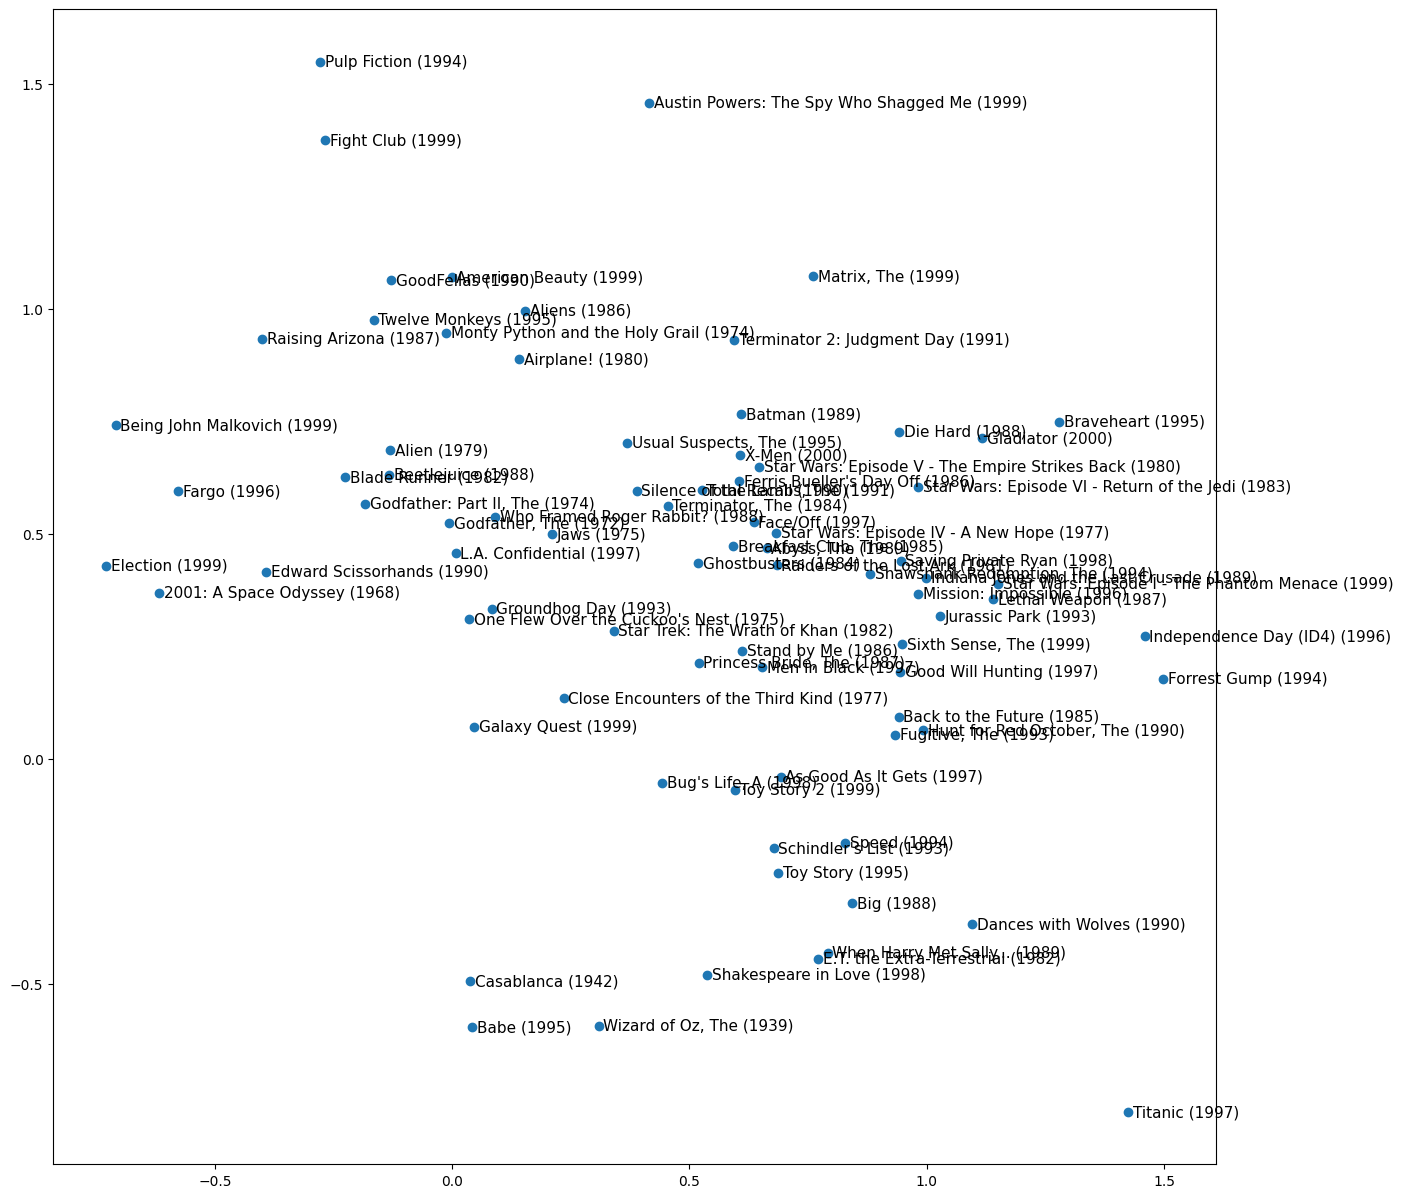

In [ ]:
nums = most_rated_movies_num[:80]
txt_movies_names = [numitem_2_name[i] for i in nums]
X = latent_fac[nums,1]
Y = latent_fac[nums,2]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(txt_movies_names, X, Y):
    plt.text(x+0.01,y-0.01,i, fontsize=11)
plt.show()

bold text#### ANS: Similar movies seem to be clustered and certain genres are clusterede togther in specific areas of the plot. For instance, When Harry Met Sally, Titantic, Shakespeare in Love are all Romantic Movies and located in the bottom left of the plot.

## Predict your own ratings

Now that we have succesfully trained a model, let's see how to deal with the situation where we have a new user. How can we make recommendations to new users?

It turns out that we can utilize the learned movie embedding vectors to estimate new users' embedding vector, based on a few ratings from them. You may have noticed that when you sign up for services such as Pandora and Netflix, they tend to ask you a few questions about what movie or music you like; this is how they come up with your initial collaborative filtering recommendations.


- First, give 40 ratings between 1-5 to the movies that your team watched before among the mostly rated movies;

In [ ]:
import pandas as pd

# Calculate the value counts for 'item_name'
value_counts = all_ratings['item_name'].value_counts()

# Convert the value counts to a DataFrame
top_movies_df = value_counts.reset_index()

# Rename the columns appropriately
top_movies_df.columns = ['item_name', 'count']

# Display the DataFrame
top_movies_df.head()

,item_name,count
0,American Beauty (1999),3428
1,Star Wars: Episode IV - A New Hope (1977),2991
2,Star Wars: Episode V - The Empire Strikes Back...,2990
3,Star Wars: Episode VI - Return of the Jedi (1983),2883
4,Jurassic Park (1993),2672


In [ ]:
my_ratings = [
    ("American Beauty (1999)", 4),
    ("Star Wars: Episode IV - A New Hope (1977)", 4),
    ("Star Wars: Episode V - The Empire Strikes Back (1980)", 4),
    ("Star Wars: Episode VI - Return of the Jedi (1983)", 3),
    ("Jurassic Park (1993)", 3),
    ("Saving Private Ryan (1998)", 3),
    ("Terminator 2: Judgment Day (1991)", 3),
    ("Matrix, The (1999)", 4),
    ("Back to the Future (1985)", 3),
    ("Silence of the Lambs, The (1991)", 2),
    ("Men in Black (1997)", 4),
    ("Raiders of the Lost Ark (1981)", 3),
    ("Fargo (1996)", 3),
    ("Sixth Sense, The (1999)", 4),
    ("Braveheart (1995)", 1),
    ("Shakespeare in Love (1998)", 3),
    ("Princess Bride, The (1987)", 2),
    ("Schindler's List (1993)", 4),
    ("L.A. Confidential (1997)", 2),
    ("Groundhog Day (1993)", 3),
    ("E.T. the Extra-Terrestrial (1982)", 3),
    ("Star Wars: Episode I - The Phantom Menace (1999)", 4),
    ("Being John Malkovich (1999)", 2),
    ("Shawshank Redemption, The (1994)", 4),
    ("Godfather, The (1972)", 4),
    ("Forrest Gump (1994)", 3),
    ("Ghostbusters (1984)", 3),
    ("Pulp Fiction (1994)", 2),
    ("Terminator, The (1984)", 3),
    ("Toy Story (1995)", 4),
    ("Alien (1979)", 3),
    ("Total Recall (1990)", 2),
    ("Fugitive, The (1993)", 4),
    ("Gladiator (2000)", 4),
    ("Aliens (1986)", 1),
    ("Blade Runner (1982)", 2),
    ("Who Framed Roger Rabbit? (1988)", 4),
    ("Stand by Me (1986)", 3),
    ("Usual Suspects, The (1995)", 3),
    ("Babe (1995)", 1)
]

# Map each movie to its rating directly
movie_to_rating = {movie: rating for movie, rating in my_ratings}

# Get the total number of movies
total_movies = len(my_ratings)

# Create a list of ratings based on the order of movies in 'my_ratings'
my_ratings_vec = [movie_to_rating[movie] for movie, _ in my_ratings]

In [ ]:
my_ratings_reshaped = np.array(my_ratings_vec)
my_ratings_reshaped.shape

(40,)


- Second, compute your own embedding vector `my_emb_np` and `my_emb_bias` by running an ordinary least squares with L_2 regularization based on your ratings and the previously computed movie embedding vectors. In other words, `item_emb_np` is the co-variate and your own 40 ratings are the response.

  Hint: you may use the [ridge regression (linear regression with L2 regularization)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) in the sklearn package.

In [ ]:
#TODO: compute your own embedding vector and bias
from sklearn.linear_model import Ridge
import numpy as np

# Convert ratings to a NumPy array
ratings_array = np.array([rating for _, rating in my_ratings])

# Get indices of rated movies
rated_indices = [name_2_numitem[movie] for movie, _ in my_ratings]

# Extract embeddings for the rated movies
movie_embeddings = item_emb_np[rated_indices]

# Create and train the Ridge regression model
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(movie_embeddings, ratings_array)

# Extract the learned embedding and bias
my_emb_np = ridge_model.coef_
my_emb_bias = ridge_model.intercept_

-  Then compute the predicted ratings for all movies using your embedding vectors and biases, together with the movie embedding vectors and biases.

In [ ]:
# compute pred_ratings
pred_ratings = np.dot(item_emb_np, my_emb_np.T) + my_emb_bias
print(pred_ratings)

[3.7753634 3.7453063 4.0295887 ... 2.5688004 3.3058944 3.5269814]


- Finally, among all movies that you haven't rated, output the top 10 movies with the highest predicted ratings.

In [ ]:
# output the top 10 movies with the highest predicted ratings.
# Extracting the movie titles ranked from 41 to 80
my_movies = top_movies_df['item_name'][40:80].tolist()

# Convert movie titles to their corresponding indices
movie_indices = [name_2_numitem[movie] for movie in my_movies]

# Retrieve predicted ratings for these movies
predicted_ratings_for_my_movies = pred_ratings[movie_indices]

# Pair each movie from 'my_movies' with the predicted rating
movies_with_predicted_ratings = list(zip(my_movies, predicted_ratings_for_my_movies))

# Sort the movies based on predicted ratings in descending order
sorted_movies = sorted(movies_with_predicted_ratings, key=lambda x: x[1], reverse=True)

# Print the top 10 movies with their predicted ratings
print("\nTop 10 Movies with the Highest Predicted Ratings:")
for title, predicted_rating in sorted_movies[:10]:
    print(f"{title}: Predicted Rating = {predicted_rating}")


Top 10 Movies with the Highest Predicted Ratings:
Galaxy Quest (1999): Predicted Rating = 5.668586730957031
X-Men (2000): Predicted Rating = 5.20661735534668
Face/Off (1997): Predicted Rating = 5.156571865081787
Independence Day (ID4) (1996): Predicted Rating = 5.053112030029297
Speed (1994): Predicted Rating = 5.021910190582275
When Harry Met Sally... (1989): Predicted Rating = 4.9562273025512695
Good Will Hunting (1997): Predicted Rating = 4.672736644744873
Breakfast Club, The (1985): Predicted Rating = 4.2131805419921875
Jaws (1975): Predicted Rating = 3.9551329612731934
Toy Story 2 (1999): Predicted Rating = 3.8581671714782715


**Question**: How do you feel about the predicted ratings? Do you like these top 10 movies? Include your answer in your report.

ANS: The majority of the predicted ratings is kind of good, and we like them. Still one or two movie is unexpected, like Toy Story 2.

---
## Movie valuation

The rating data provided the company like Netflix information about the value of a movie that was not available to movie production studios. The collaborative filting algorithm allows Netflix to accurately value the content in a data-driven manner. For example, if Netflix were offered the opportunity to license *Toy Story (1995)*, it would need to provide Disney an initial quote of the license fee. Traditional methods suggest looking at box office returns of *Toy Story* franchise and projecting the potential value of the film.

In this following, we will explore a novel approach to determine the valuation of a movie based on the predicted ratings. We make the following simplifying assumpitons (Note that these assumptions can be certainly relaxed with more complicated procedures and data):

- **Netflix are focusing on the top 1000 active users and 1000 popular movies (with the most number of observed ratings).** In other words, in the following movie valuation calculation, we just consider the top 1000 activie users and 1000 popular movies, disregarding the rest.

- For each user, the total amount of viewing time is proportional to the number of observed ratings. In other words, more active users spend more time on Netflix;

- For each given user, the viewing time across different movies follow a [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), that is

  $$
    \text{Viewtime of movie $i$} \propto \frac{1}{\text{rank of } i }
  $$
  Here the rank of $i$ is determined by sorting the **predicted rating** of movie $i$ by the user in descending order. In other words, the user spend less time on watching movies with lower ratings.

- Netflix has a fixed total budget of 1 Billion dollars to license the content;

- Netflix estimates the value of a movie based on the expected share of customer viewing time of the movie on its platform:
$$
\text{Value of a movie $i$ } = \frac{\text{View time of movie $i$ of all users}}{\text{Total view time of all users} } \times \text{Total content license budget}
$$


### Compute the value of each movie

In [ ]:
# Get indices for top 1000 active users and top 1000 mostly rated movies
top1000_user_num = pd.Series(all_ratings["user_num"].value_counts()[:1000].index, name="user_num")
top1000_item_num = pd.Series(all_ratings["item_num"].value_counts()[:1000].index, name="item_num")
# Construct dataframes for storing predicted ratings
pred_ratings = pd.merge(top1000_user_num, top1000_item_num, how="cross")
cartesian_user_num = torch.from_numpy(np.asarray(pred_ratings["user_num"])).to(device)
cartesian_item_num = torch.from_numpy(np.asarray(pred_ratings["item_num"])).to(device)

In [ ]:
pred_ratings.head()

,user_num,item_num
0,4168,2651
1,4168,253
2,4168,1106
3,4168,1120
4,4168,466


In [ ]:
# sanity check: # of rows in pred_ratings == # of active users (1000) x # of popular items (1000)
pred_ratings.shape[0] == 1000 * 1000

True

In [ ]:
#TODO: use your optimized model to compute the predicted ratings among the top 1000 active users and top 1000 popular movies
all_predicted_ratings = []
batch_size = 100
for i in range(0, len(pred_ratings), batch_size):
  all_predicted_ratings.extend(
      best_model._net(cartesian_user_num[i:i+batch_size],
                cartesian_item_num[i:i+batch_size]).cpu().detach().numpy().tolist())
pred_ratings['pred_ratings']=all_predicted_ratings

In [ ]:
# Each user's total viewtime is stored in Series user_total_viewtime
user_total_viewtime = all_ratings["user_num"].value_counts()[:1000] / all_ratings["user_num"].value_counts()[:1000].sum()
user_total_viewtime.name = "user_total_viewtime"
user_total_viewtime.index.name = "user_num"
pred_ratings = pd.merge(pred_ratings, user_total_viewtime, left_on="user_num", right_on="user_num", how="left")

In [ ]:
pred_ratings.head()

,user_num,item_num,pred_ratings,user_total_viewtime
0,4168,2651,5.327432,0.00449
1,4168,253,4.959877,0.00449
2,4168,1106,4.500669,0.00449
3,4168,1120,4.242913,0.00449
4,4168,466,4.924698,0.00449


In [ ]:
# Each user per each movie viewtime: pred_all_ratings["user_item_viewtime"] = ["1/user_rank"] / ["sum(1/user_rank)"] * ["user_total_viewtime"]
# these wordy codes are to reduce RAM consumption otherwise Colab may crush
pred_ratings["1/user_rank"] = 1/pred_ratings.groupby("user_num")["pred_ratings"].rank(method = "min", ascending = False)
sum_inverse_user_rank = pred_ratings.groupby("user_num")["1/user_rank"].sum()
sum_inverse_user_rank.name = "sum(1/user_rank)"
pred_ratings = pd.merge(pred_ratings, sum_inverse_user_rank, left_on="user_num", right_on="user_num", how="left")
pred_ratings["user_item_viewtime"] = pred_ratings["1/user_rank"] / pred_ratings["sum(1/user_rank)"] * pred_ratings["user_total_viewtime"]

In [ ]:
pred_ratings

,user_num,item_num,pred_ratings,user_total_viewtime,1/user_rank,sum(1/user_rank),user_item_viewtime
0,4168,2651,5.327432,0.004490,0.047619,7.485471,2.856540e-05
1,4168,253,4.959877,0.004490,0.011905,7.485471,7.141351e-06
2,4168,1106,4.500669,0.004490,0.004608,7.485471,2.764394e-06
3,4168,1120,4.242913,0.004490,0.003115,7.485471,1.868765e-06
4,4168,466,4.924698,0.004490,0.011111,7.485471,6.665261e-06
...,...,...,...,...,...,...,...
999995,3411,2126,3.989392,0.000569,0.001541,7.485471,1.170359e-07
999996,3411,67,4.115575,0.000569,0.001852,7.485471,1.406599e-07
999997,3411,2614,4.589793,0.000569,0.006410,7.485471,4.868995e-07
999998,3411,1608,3.788660,0.000569,0.001276,7.485471,9.688306e-08


In [ ]:
# sanity check: sum of user_item_viewtime == 1
pred_ratings["user_item_viewtime"].sum()

1.0

In [ ]:
# compute each movie's value
budget =  1000000000
#TODO: compute and store the values of movies based on pred_ratings
movie_values = pred_ratings.groupby("item_num")["user_item_viewtime"].sum()/pred_ratings.groupby('item_num')['user_item_viewtime'].sum().sum()*budget
movie_values.name = "item_value"

In [ ]:
# replace item_num by item_name
movie_values = movie_values.to_frame()
movie_values["item_name"] = [numitem_2_name[item_num] for item_num in movie_values.index]
movie_values = movie_values.set_index("item_name").squeeze(axis=1)

In [ ]:
movie_values.head()

item_name
Toy Story (1995)           5.085595e+06
Jumanji (1995)             2.095923e+05
Grumpier Old Men (1995)    1.773098e+05
Heat (1995)                4.771563e+05
Sabrina (1995)             2.055669e+05
Name: item_value, dtype: float64

In [ ]:
# sanity check: sum of movie values == budget
movie_values.sum() == budget

True

### Output the top valued movies

**Question**: Include your answer in the report.

- What is your estimated value of *Toy Story (1995)*?

- What are the top 10 mostly valued movies?


In [ ]:
# your code
movie_values.sort_values(ascending=False).head(10)

item_name
Godfather, The (1972)                        2.708019e+07
Star Wars: Episode IV - A New Hope (1977)    2.311227e+07
Pulp Fiction (1994)                          1.957147e+07
American Beauty (1999)                       1.746594e+07
Raiders of the Lost Ark (1981)               1.500318e+07
Fargo (1996)                                 1.424284e+07
Casablanca (1942)                            1.412969e+07
Schindler's List (1993)                      1.387468e+07
Sixth Sense, The (1999)                      1.374704e+07
Shawshank Redemption, The (1994)             1.343221e+07
Name: item_value, dtype: float64


### Compare the output with the mostly rated movies. Identify the discrepancies.

**Question**: Include your answers in your report.

- What are the movies that are top 30 rated but not in top 30 valued?
- What do you think about this approach of movie valuation? How does it compare with the approach based on the popularity of the movies?




In [ ]:
# your code
# Sort 'movie_values' in descending order and select the top 30
top_30_by_value = movie_values.sort_values(ascending=False).head(30)
top_30_value_indices = set(top_30_by_value.index)

# Get the top 30 movies from 'all_ratings' based on their count
top_30_most_rated = all_ratings['item_name'].value_counts().head(30)
top_30_rated_indices = set(top_30_most_rated.index)

# Calculate the difference: movies that are in the top 30 rated but not in the top 30 by value
difference_in_top_30 = list(top_30_rated_indices - top_30_value_indices)

# Print the list
difference_in_top_30

['Ghostbusters (1984)',
 'Jurassic Park (1993)',
 'L.A. Confidential (1997)',
 'Terminator, The (1984)',
 'Star Wars: Episode I - The Phantom Menace (1999)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Saving Private Ryan (1998)',
 'E.T. the Extra-Terrestrial (1982)',
 'Shakespeare in Love (1998)',
 'Men in Black (1997)',
 'Toy Story (1995)',
 'Braveheart (1995)',
 'Groundhog Day (1993)',
 'Back to the Future (1985)',
 'Terminator 2: Judgment Day (1991)']

#### ANS: Ranking movies by popularity is straightforward but can be biased when movies have only few reviews or a higher-than-average prestige. Besides, the popularity may be generated by a certain group of fans and don't apply to other audience. The approach of movie valuation is more fair and can be generalized in the recommendation system.